In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from matplotlib import animation
from matplotlib.animation import PillowWriter

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

# Extract Data

In [2]:
name = '10k_0.05M_t5'

theta = 0.05
eps = 0.0075
      
b = 0.1      

One can decide whether to extract time, positions and velocities from the `.out` file or to import the data from previously-saved numpy arrays.

In [3]:
import_from_saved_nparrays = True
save_arrays = False

# Import the data from previously-saved numpy arrays...
if import_from_saved_nparrays:
    time = np.load('numpy_arrays/'+name+'_time.npy')
    masses = np.load('numpy_arrays/'+name+'_masses.npy')
    x = np.load('numpy_arrays/'+name+'_x.npy')
    y = np.load('numpy_arrays/'+name+'_y.npy')
    z = np.load('numpy_arrays/'+name+'_z.npy')
    vx = np.load('numpy_arrays/'+name+'_vx.npy')
    vy = np.load('numpy_arrays/'+name+'_vy.npy')
    vz = np.load('numpy_arrays/'+name+'_vz.npy')
    N = int(len(x[:,0]))

    print(f'This is the data of {N} particles at {len(time)} time intervals')
    
    
# or extract it from the '.out' file
else:
    # Extract the data by reading one line of the file at a time
    extension = '.out'

    file = open('./friction_'+name+extension, 'r')

    N = int(file.readline())
    time = []
    masses = []
    x = []
    y = []
    z = []
    vx = []
    vy = []
    vz = []

    step = 3 + 3*N
    i = 1
    j = 0

    while(True):   
        line = file.readline()

        if line=='':
            file.close()
            break
        
        i += 1

        k = i-j*step
        if (k==3): time.append(float(line))
        elif (j==0 and (k > 3 and k <= 3+N)): 
            masses.append(float(line))
        elif (k > 3+N and k <= 3+2*N): 
            line = [float(x) for x in line.split()]
            x.append(line[0])
            y.append(line[1])
            z.append(line[2])
        elif (k > 3+2*N and k <= 3+3*N):
            line = [float(x) for x in line.split()]
            vx.append(line[0])
            vy.append(line[1])
            vz.append(line[2])

        if i%step==0: j += 1
        
    # Convert the data from lists to numpy arrays 
    time = np.array(time)
    masses = np.array(masses)
    x = np.array(x).reshape(len(time), N).T
    y = np.array(y).reshape(len(time), N).T
    z = np.array(z).reshape(len(time), N).T
    vx = np.array(vx).reshape(len(time), N).T
    vy = np.array(vy).reshape(len(time), N).T
    vz = np.array(vz).reshape(len(time), N).T

    print(f'This is the data of {N} particles at {len(time)} time intervals')
    
    
    # If you want, you can save the data in form of numpy arrays
    if save_arrays:
        np.save('numpy_arrays/'+name+'_time.npy', time)
        np.save('numpy_arrays/'+name+'_masses.npy', masses)
        np.save('numpy_arrays/'+name+'_x.npy', x)
        np.save('numpy_arrays/'+name+'_y.npy', y)
        np.save('numpy_arrays/'+name+'_z.npy', z)
        np.save('numpy_arrays/'+name+'_vx.npy', vx)
        np.save('numpy_arrays/'+name+'_vy.npy', vy)
        np.save('numpy_arrays/'+name+'_vz.npy', vz)
        
M = np.sum(masses)
M_pert = masses[-1]
print(f'M = {M:.4f}')
print(f'M_pert = {M_pert:.4f}')

This is the data of 10001 particles at 2001 time intervals
M = 1.0500
M_pert = 0.0500


# Motion of the CM

Compute the position and the velocity of the center of mass as a function of time

$$\vec{r}_{CM}(t) = \dfrac{\sum_{i=1}^{N} m_i \vec{r}_i(t)}{\sum_{i=1}^{N} m_i} \:\:\: , \:\:\: \vec{r'}_i(t) = \vec{r}_i(t) - \vec{r}_{CM} (t)$$

$$\vec{v}_{CM} (t) = \dfrac{\sum_{i=1}^{N} m_i \vec{v}_i(t)}{\sum_{i=1}^{N} m_i} \:\:\: , \:\:\: \vec{v'}_i(t) = \vec{v}_i(t) - \vec{v}_{CM} (t)$$

In [4]:
CMpos_vector = np.array([np.dot(masses, x), np.dot(masses, y), np.dot(masses, z)])/M
CMpos = np.linalg.norm(CMpos_vector, axis=0)

CMvel_vector = np.array([np.dot(masses, vx), np.dot(masses, vy), np.dot(masses, vz)])/M
CMvel = np.linalg.norm(CMvel_vector, axis=0)

Compute the distance of each particle from the center of mass at each time

In [5]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

dist_particle = Dist(x, y, z, CMpos_vector[0], CMpos_vector[1], CMpos_vector[2])
print(dist_particle.shape)

(10001, 2001)


Plot the position of the center of mass as a function of time

  0%|          | 0/2001 [00:00<?, ?it/s]

100%|██████████| 2001/2001 [00:00<00:00, 2540.81it/s]


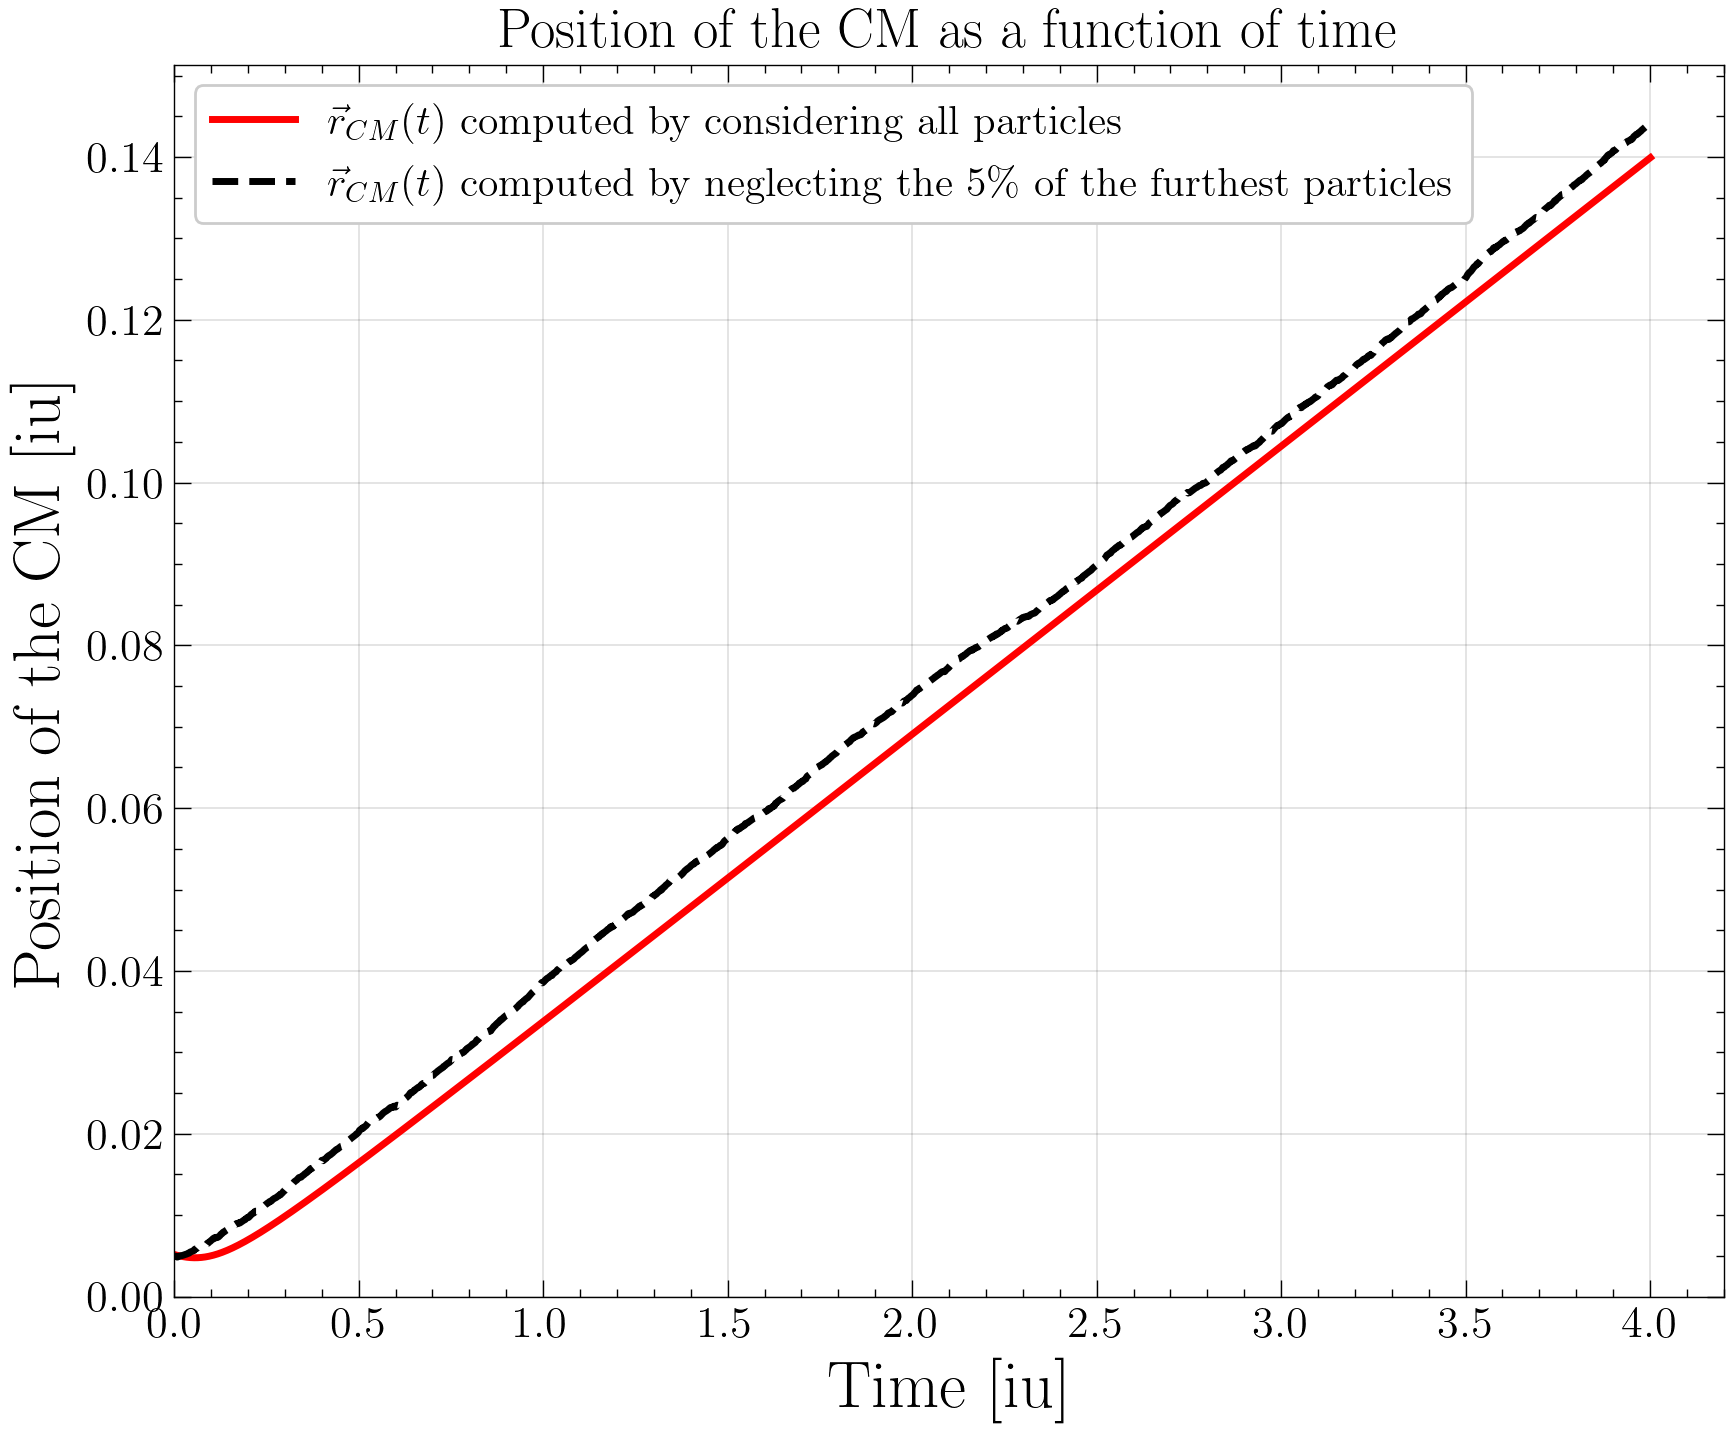

In [6]:
plt.plot(time, CMpos, color='red', lw=2.5, label='$\\vec{r}_{CM}(t)$ computed by considering all particles')

CMpos_q95_vector = np.zeros((3, len(time)))
for i in tqdm(range(len(time))):
    mask = dist_particle[:,i]<np.quantile(dist_particle[:,i], 0.95)
    CMpos_q95_vector[:,i] = np.array([np.dot(masses[mask], x[:,i][mask]), 
                                      np.dot(masses[mask], y[:,i][mask]), 
                                      np.dot(masses[mask], z[:,i][mask])])/np.sum(masses[mask])
CMpos_q95 = np.linalg.norm(CMpos_q95_vector, axis=0)

plt.plot(time, CMpos_q95, color='black', ls='--', lw=2.5, label='$\\vec{r}_{CM}(t)$ computed by neglecting the 5\% of the furthest particles')
plt.xlim(0)
plt.ylim(0)
plt.title('Position of the CM as a function of time', fontsize=20)
plt.xlabel('Time [iu]')
plt.ylabel('Position of the CM [iu]')
plt.legend(fontsize = 15);

Plot the velocity of the center of mass as a function of time

100%|██████████| 2001/2001 [00:00<00:00, 2558.31it/s]


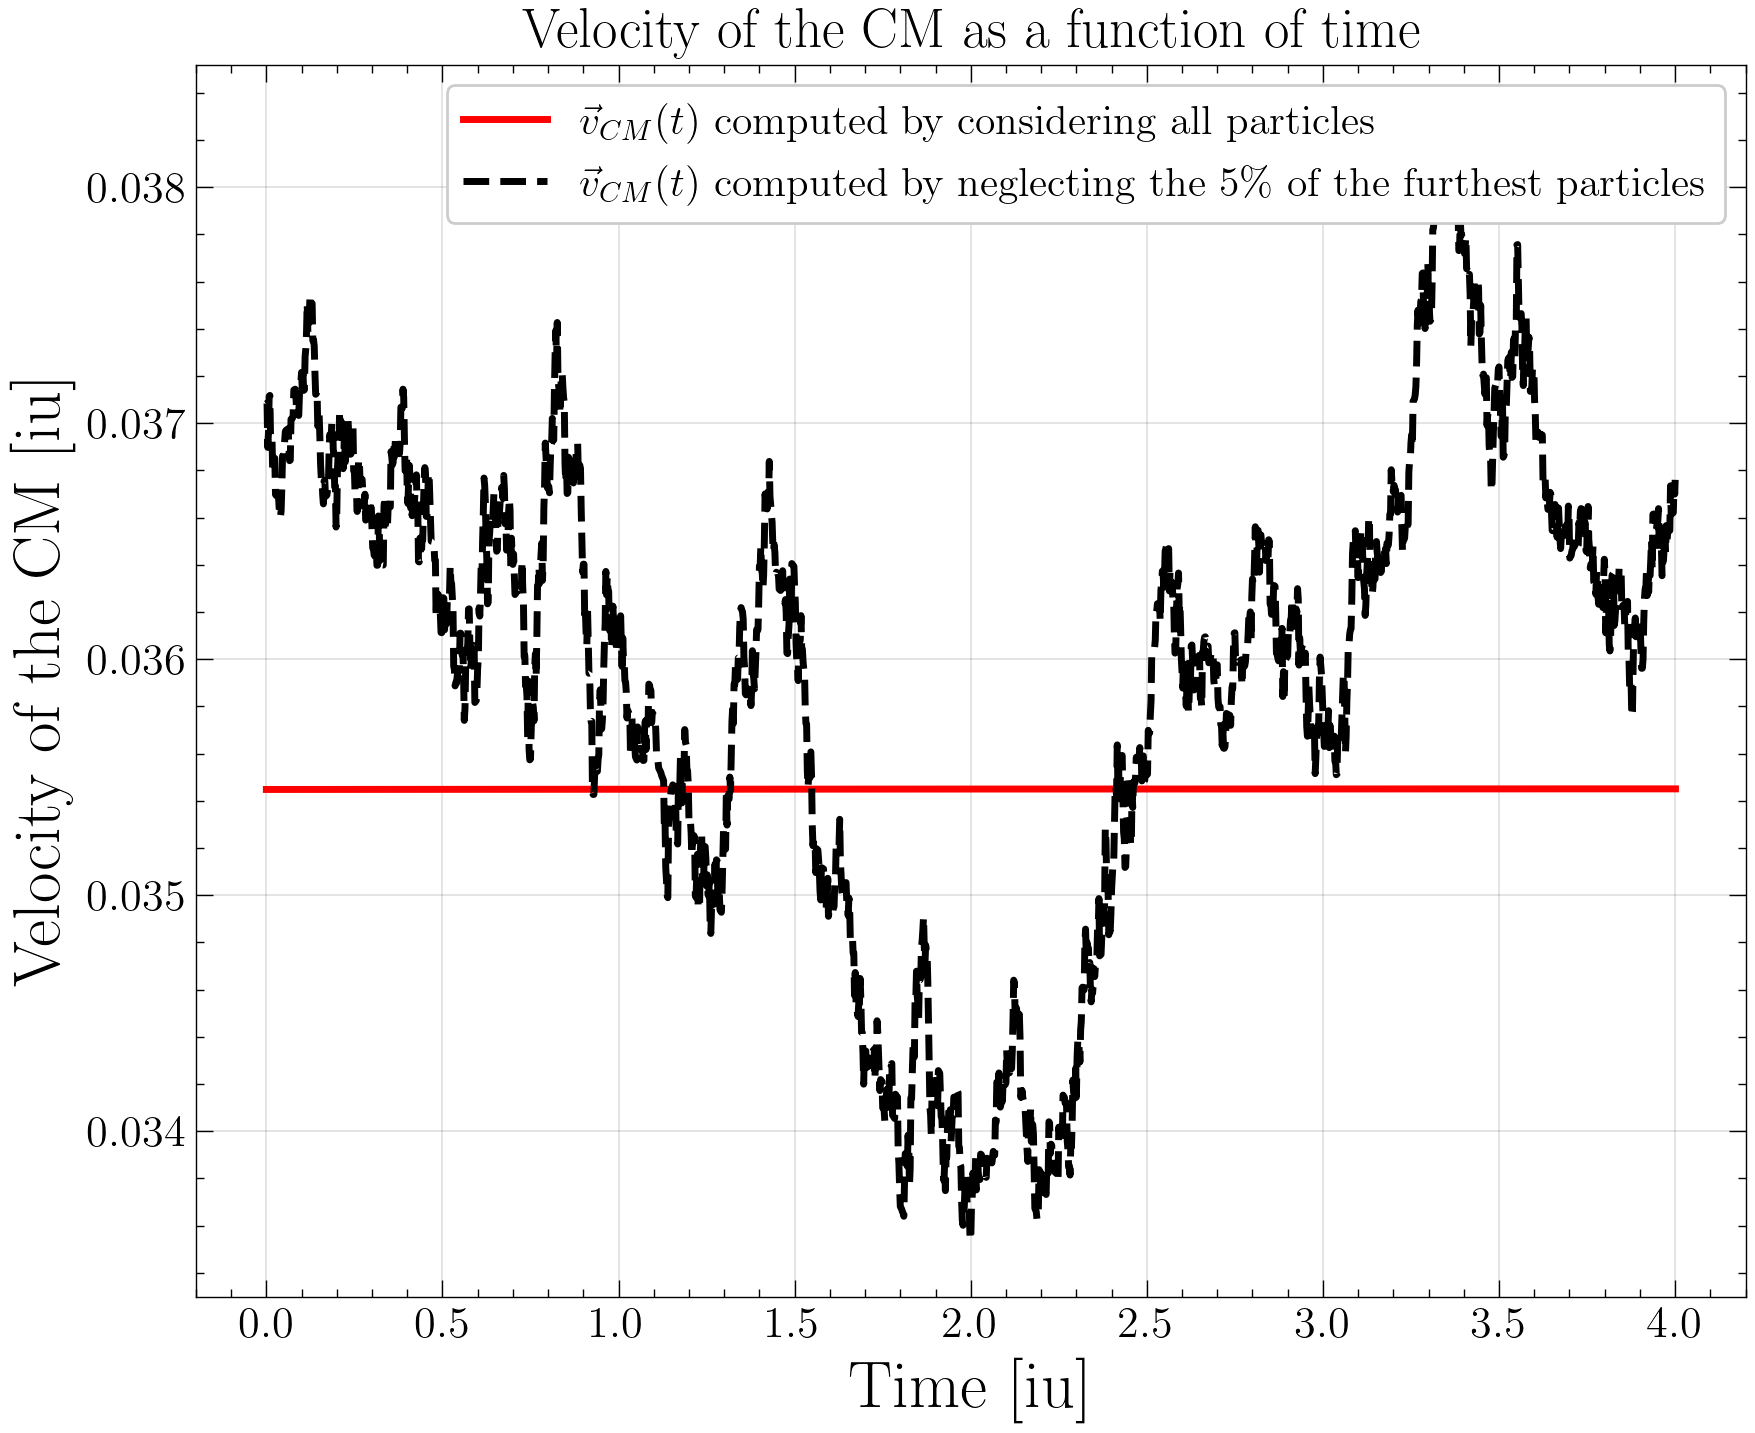

In [7]:
plt.plot(time, CMvel, color='red', lw=2.5, label='$\\vec{v}_{CM}(t)$ computed by considering all particles')

CMvel_q95_vector = np.zeros((3, len(time)))
for i in tqdm(range(len(time))):
    mask = dist_particle[:,i]<np.quantile(dist_particle[:,i], 0.95)
    CMvel_q95_vector[:,i] = np.array([np.dot(masses[mask], vx[:,i][mask]), 
                                      np.dot(masses[mask], vy[:,i][mask]), 
                                      np.dot(masses[mask], vz[:,i][mask])])/np.sum(masses[mask])
CMvel_q95 = np.linalg.norm(CMvel_q95_vector, axis=0)

plt.plot(time, CMvel_q95, color='black', ls='--', lw=2.5, label='$\\vec{v}_{CM}(t)$ computed by neglecting the 5\% of the furthest particles')
plt.title('Velocity of the CM as a function of time', fontsize=20)
plt.xlabel('Time [iu]')
plt.ylabel('Velocity of the CM [iu]')
plt.legend(fontsize = 15);

Redefine positions and velocities in the CM frame

In [8]:
x = x - CMpos_vector[0]
y = y - CMpos_vector[1]
z = z - CMpos_vector[2]
vx = vx - CMvel_vector[0]
vy = vy - CMvel_vector[1]
vz = vz - CMvel_vector[2]

We constrain our plots to boxes of length `dist_plotlimits` in each direction, which is defined as the maximum in time of the 90%-quantiles of the distances between the particles and the CM

In [9]:
dist_plotlimits = np.max(np.quantile(dist_particle, 0.9, axis=0))
dist_plotlimits

0.37518785285155576

# Orbit of the perturber

In [10]:
def v_of_r(r):
    return np.sqrt(M*r**2/(b**2+r**2)**(3/2))

dist_pert = dist_particle[-1]
v_pert = np.sqrt(vx[-1]**2 + vy[-1]**2 + vz[-1]**2)

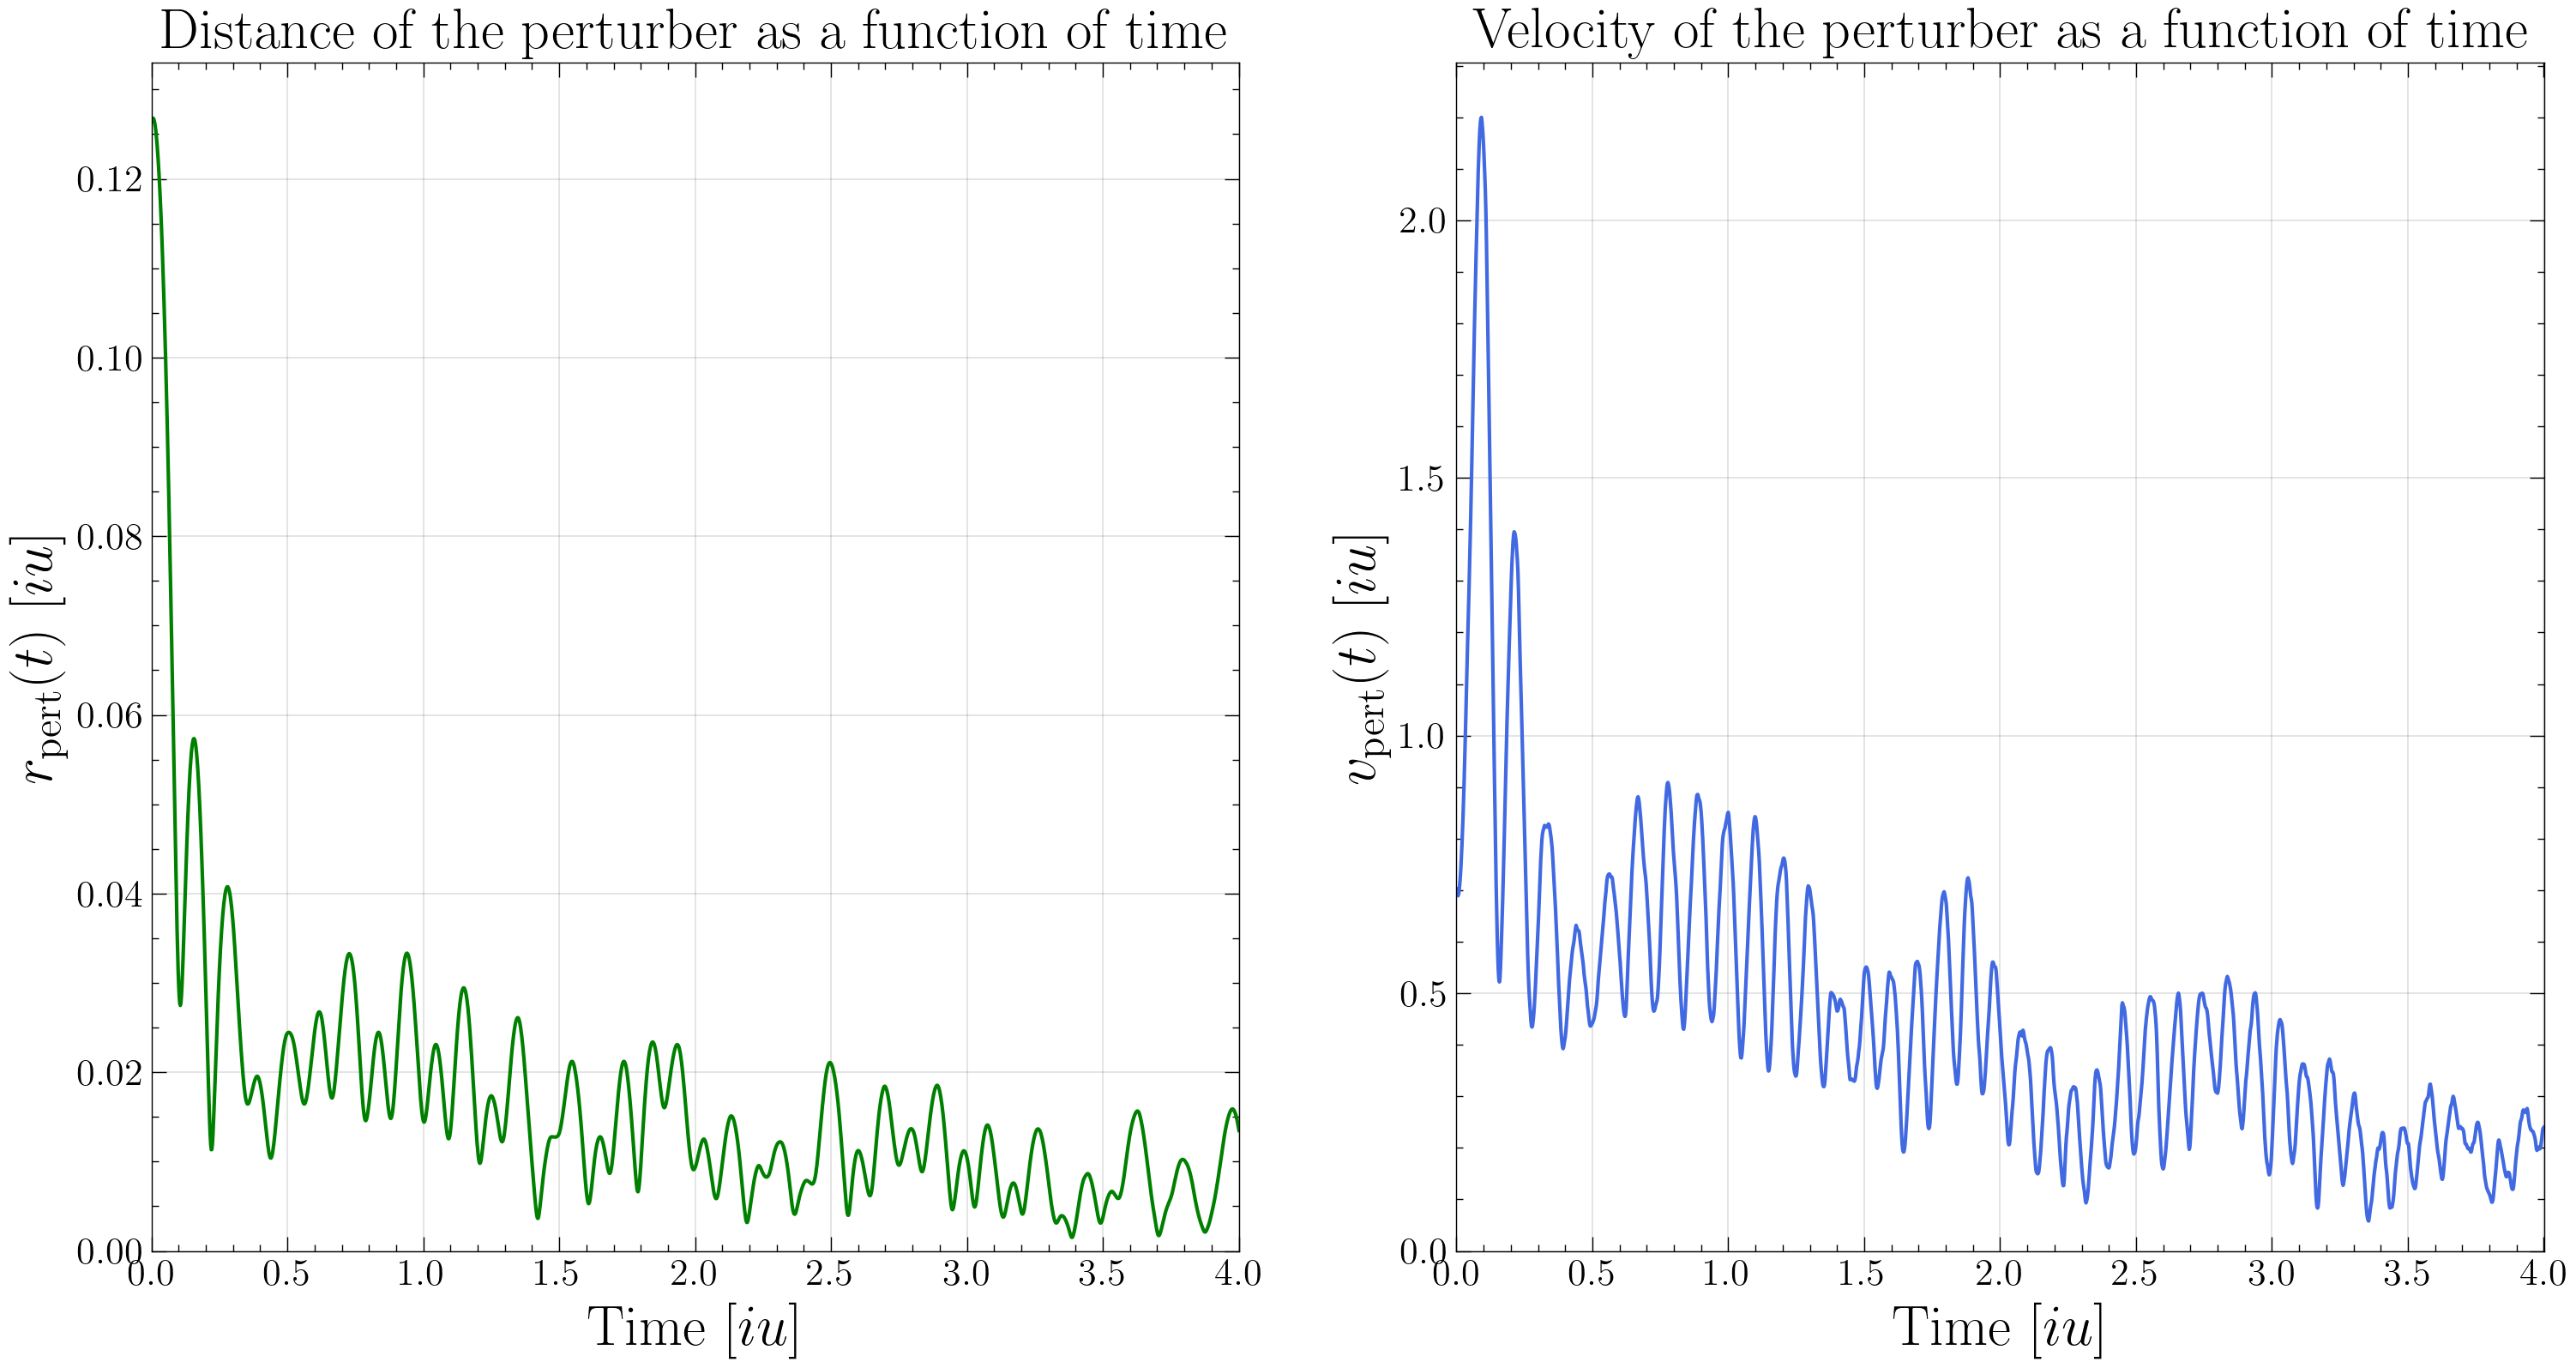

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

ax = axes[0]
ax.plot(time, dist_pert, color='green')
#ax.plot(time, v_of_r(dist_pert)*(dist_pert[0]/v_of_r(dist_pert)[0]), c='crimson', alpha=0.5)
ax.set_xlim(0, time[-1])
#ax.set_xlim(time[-100], time[-1])
ax.set_ylim(0)
ax.set_title('Distance of the perturber as a function of time')
ax.set_xlabel('Time $[iu]$')
ax.set_ylabel('$r_{\\rm{pert}} (t)$ $[iu]$')

ax = axes[1]
ax.plot(time, v_pert, color='royalblue')
#ax.plot(time, v_of_r(dist_pert)*(v_pert[0]/v_of_r(dist_pert)[0]), c='crimson', alpha=0.5)
ax.set_xlim(0, time[-1])
#ax.set_xlim(time[-100], time[-1])
ax.set_ylim(0)
ax.set_title('Velocity of the perturber as a function of time')
ax.set_xlabel('Time $[iu]$')
ax.set_ylabel('$v_{\\rm{pert}} (t)$ $[iu]$');

# Interaction between particle and perturber

In [12]:
time_index = 100

closest_to_pert_index = np.argmin(Dist(x[-1, time_index], y[-1, time_index], z[-1, time_index], x[:-1,time_index], y[:-1,time_index], z[:-1,time_index]))
print(f'The particle #{closest_to_pert_index} is the closest to the perturber at time {time[time_index]:.2f} iu.')

The particle #7920 is the closest to the perturber at time 0.20 iu.


Let's plot its angular momentum

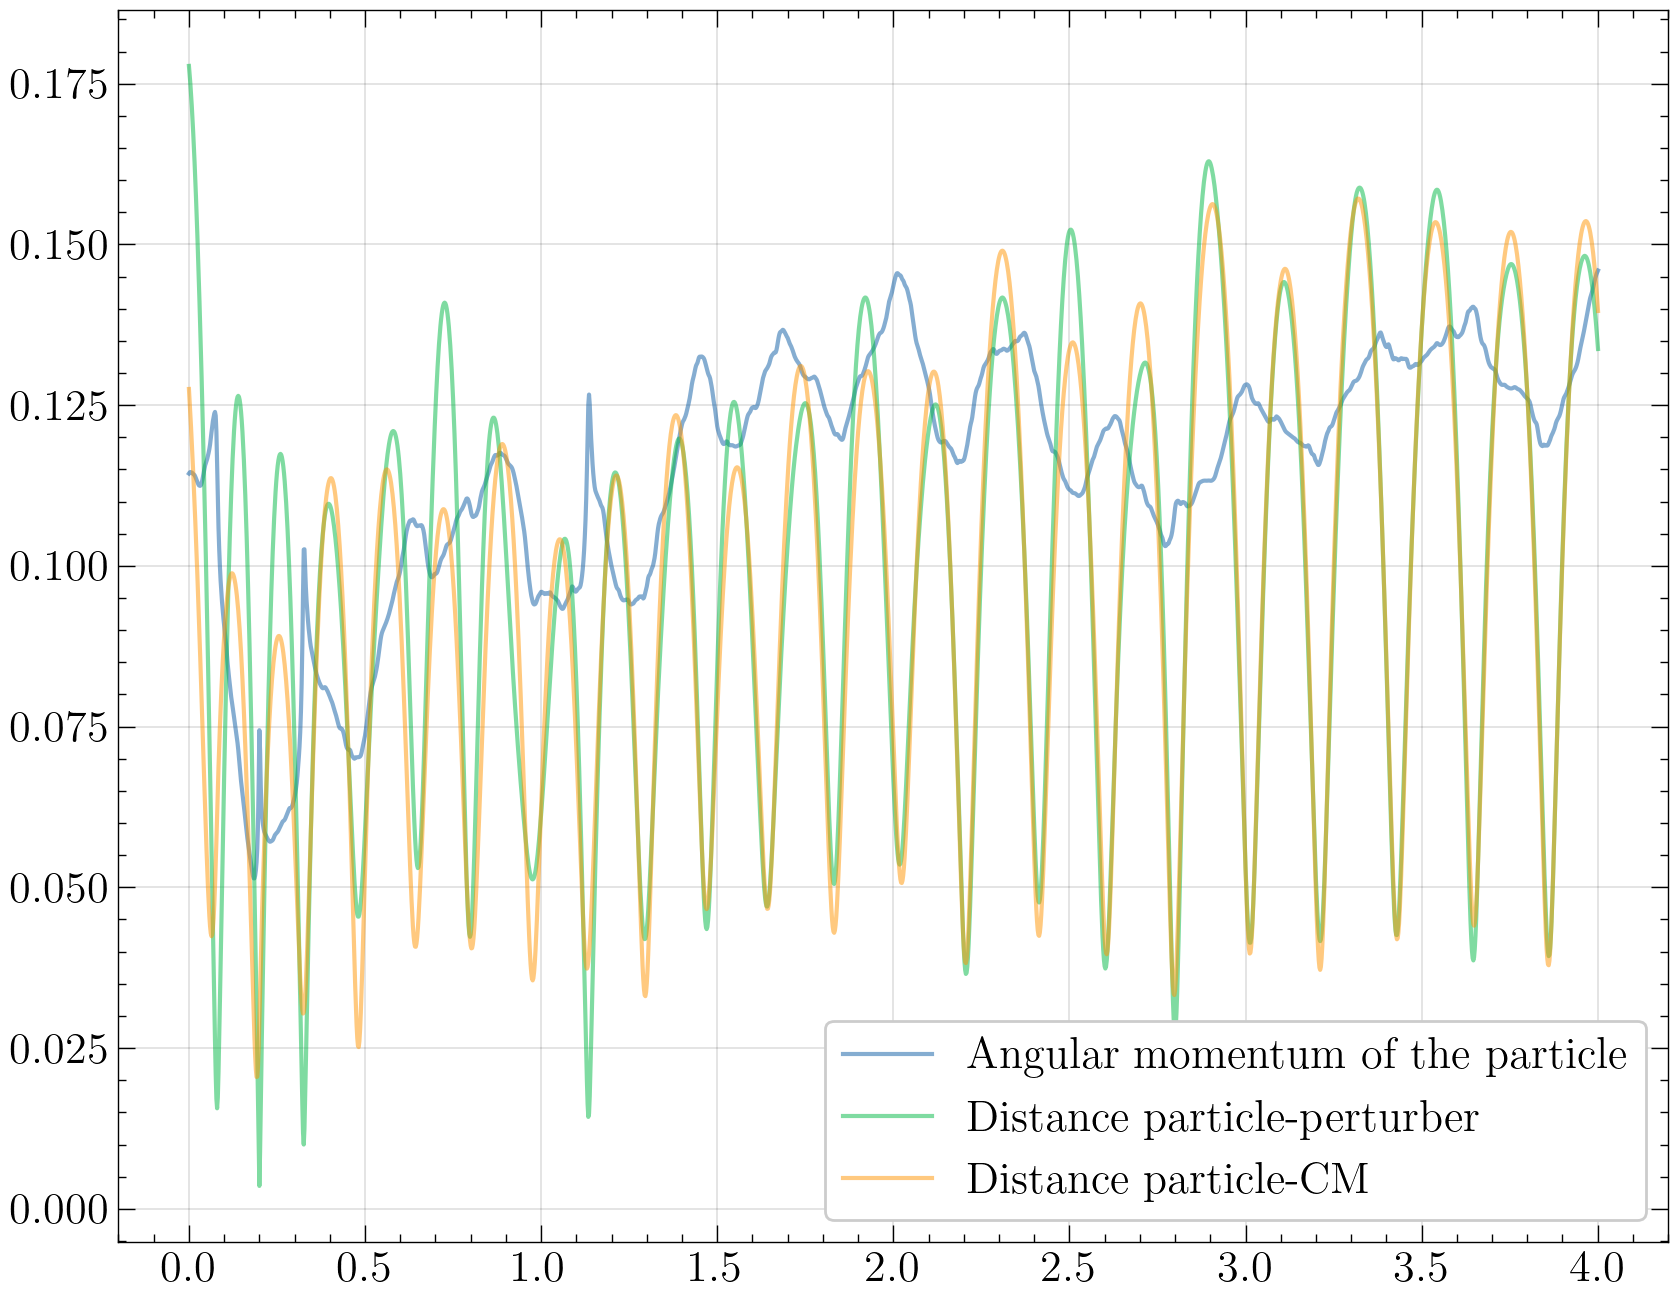

In [13]:
angmom_particle = np.linalg.norm(np.cross(np.array([x, y, z])[:,closest_to_pert_index,:].T, np.array([vx, vy, vz])[:,closest_to_pert_index,:].T), axis=1)

dist_pert_particle = Dist(x[-1, :], y[-1, :], z[-1, :], x[closest_to_pert_index,:], y[closest_to_pert_index,:], z[closest_to_pert_index,:])
plt.plot(time, angmom_particle, alpha=0.5, label='Angular momentum of the particle')
plt.plot(time, dist_pert_particle, alpha=0.5, label='Distance particle-perturber')
plt.plot(time, dist_particle[closest_to_pert_index], alpha=0.5, label='Distance particle-CM')
plt.legend();

# Animation: orbit of the perturber

In [14]:
time_interval = int(len(time)/10)
print(f'time_interval = {time[time_interval]}')

orbit_plotlimits = np.max(dist_pert)
print(f'orbit_plotlimits = {orbit_plotlimits}')

time_interval = 0.3999984
orbit_plotlimits = 0.1267960642638237


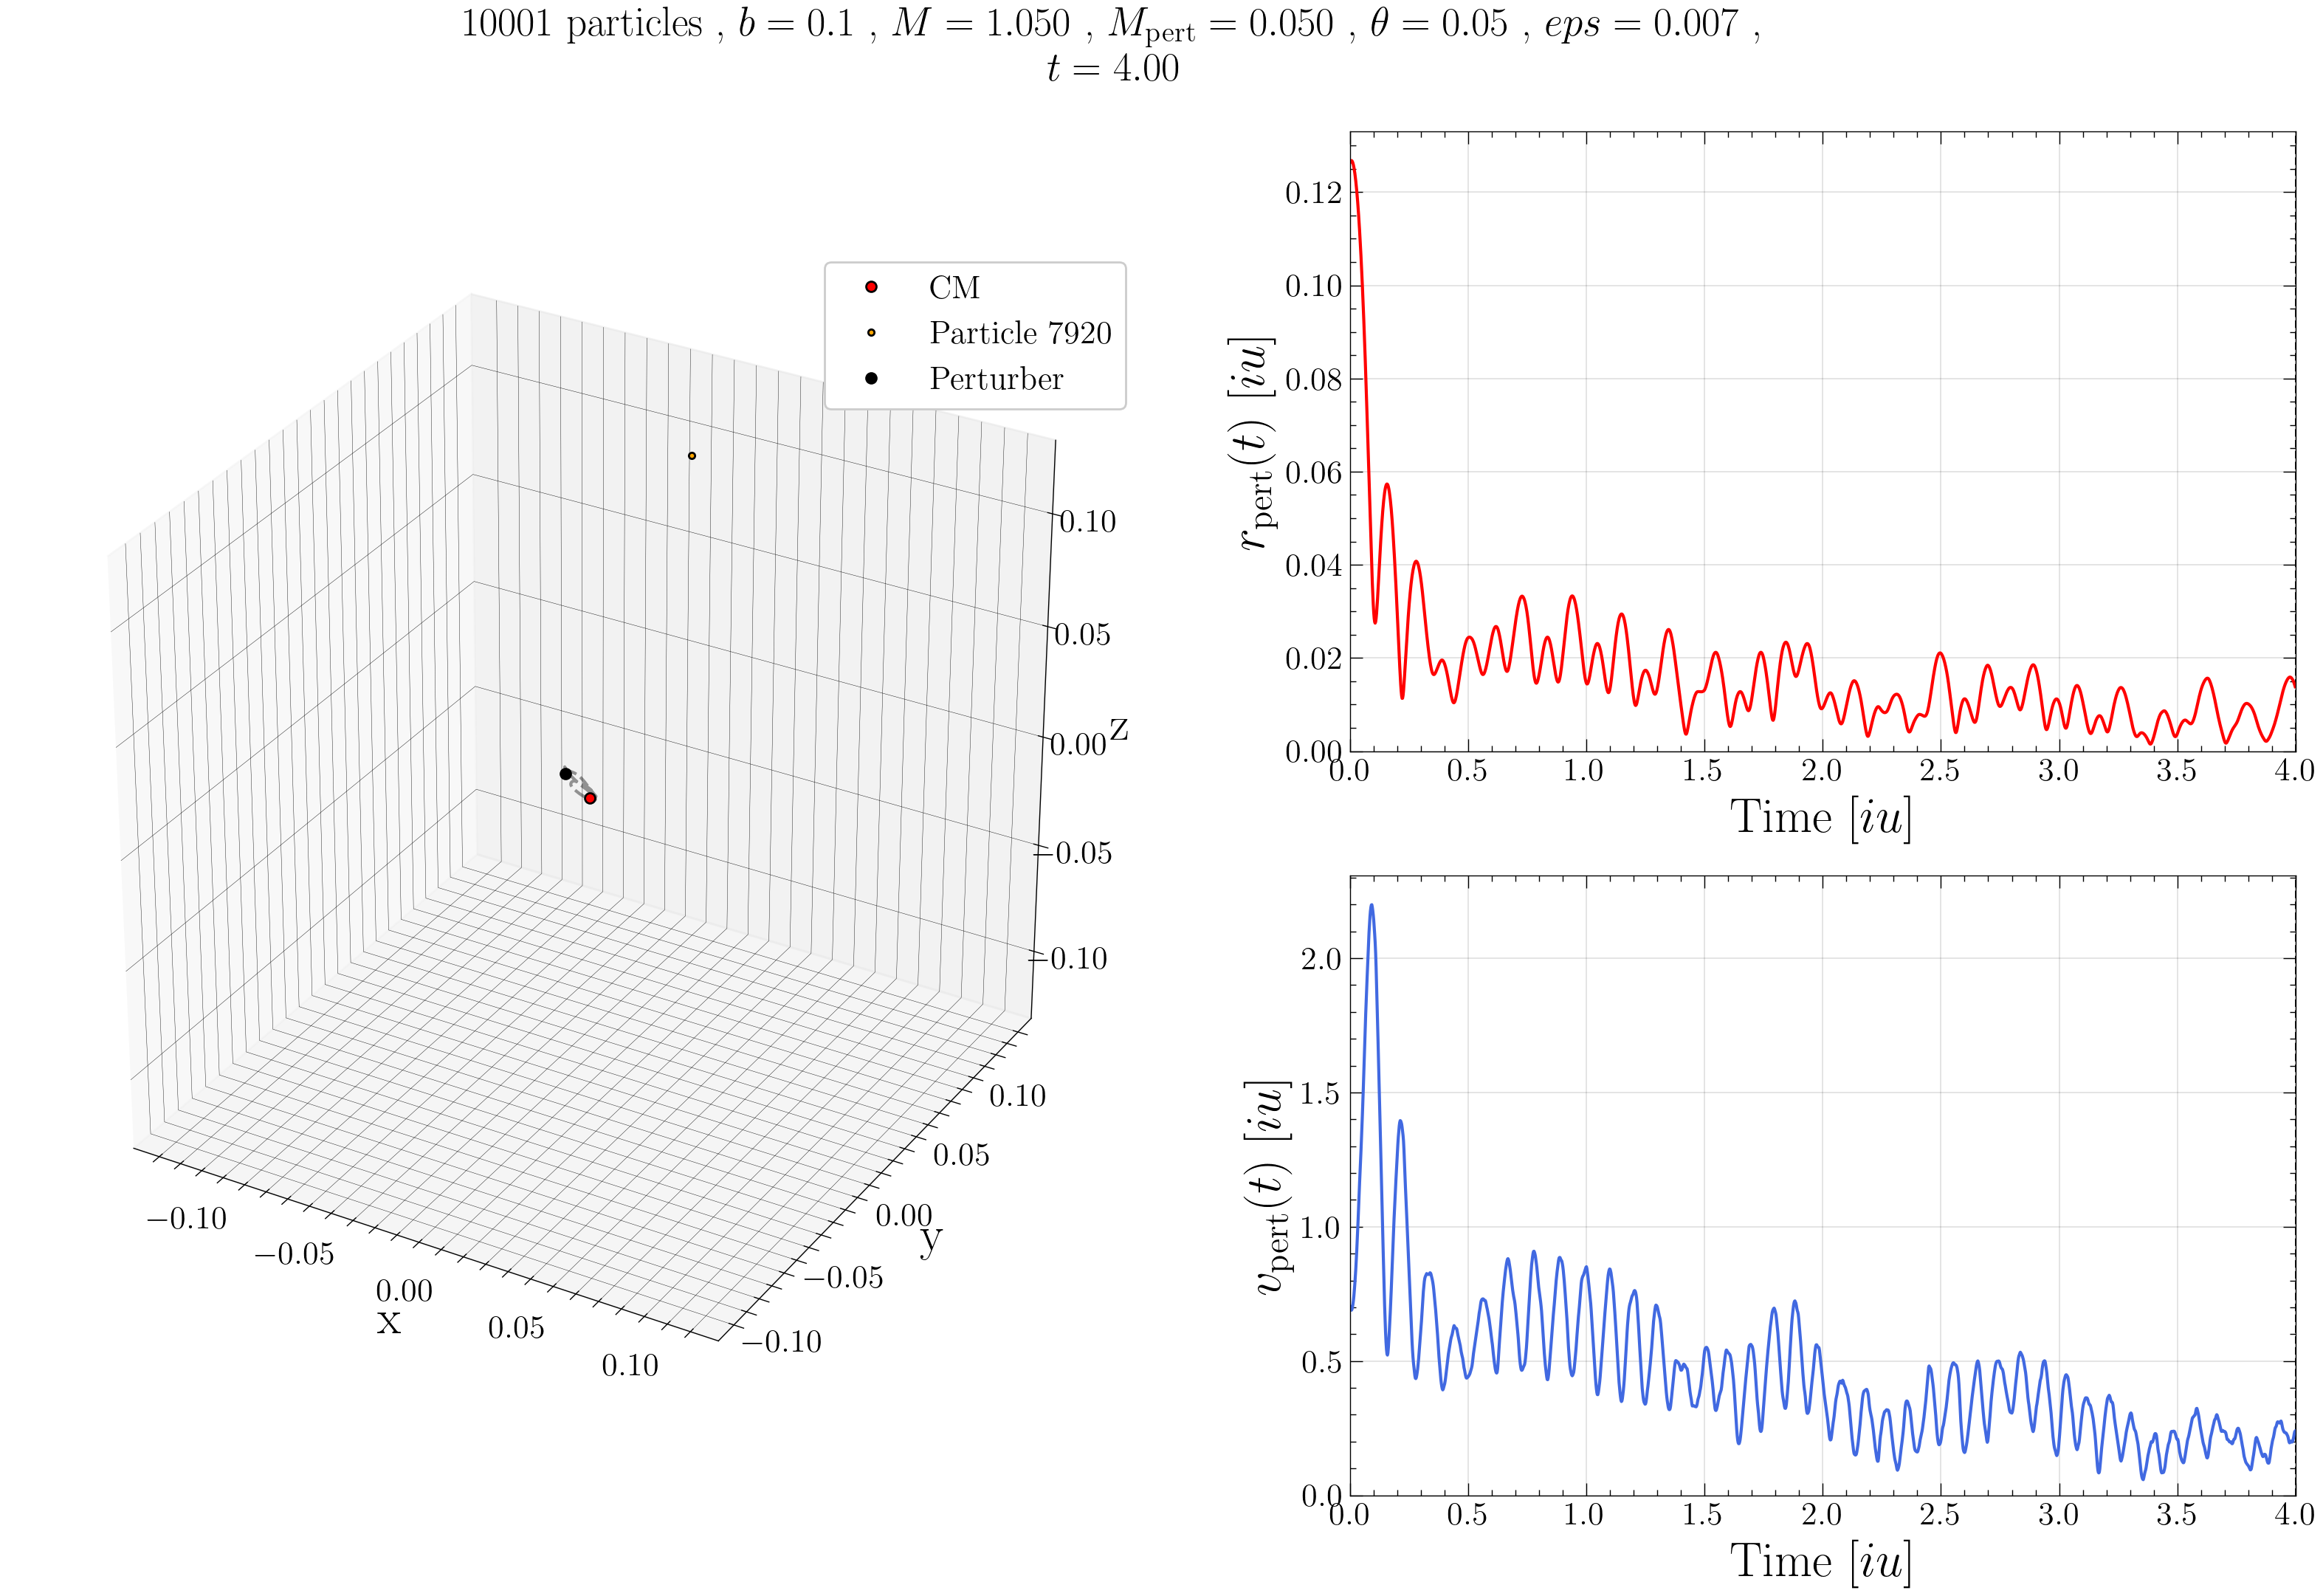

In [15]:
animate_orbit = True

if animate_orbit:
    # if len(time)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 2, width_ratios=[1.2, 1])
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{pert}}}} = {M_pert:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$', fontsize=20, y=0.95)   

    ax2.set_xlim(0, time[-1])
    ax2.set_ylim(0, 1.05*np.max(dist_pert))
    ax2.set_xlabel('Time $[iu]$')
    ax2.set_ylabel('$r_{\\rm{pert}} (t)$ $[iu]$')
    dist_pert_plot, = ax2.plot([], [], color='red')
    dist_pert_plot_vline = ax2.axvline(0, linestyle='--', lw=1, color='black', zorder=0)
    
    ax3.set_xlim(0, time[-1])
    ax3.set_ylim(0, 1.05*np.max(v_pert))
    ax3.set_xlabel('Time $[iu]$')
    ax3.set_ylabel('$v_{\\rm{pert}} (t)$ $[iu]$')
    v_pert_plot, = ax3.plot([], [], color='royalblue')
    v_pert_plot_vline = ax3.axvline(0, linestyle='--', lw=1, color='black', zorder=0)
    
    def animate(i):
        t = k*i
        time_left = t - time_interval
        
        print(f'frame {(i+1)}/{nframes}, {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{pert}}}} = {M_pert:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[t]:.2f}$')
        
        # ax1
        ax1.clear()
        ax1.set_box_aspect([1, 1, 1])
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('z')
        ax1.set_xlim(-orbit_plotlimits, orbit_plotlimits)
        ax1.set_ylim(-orbit_plotlimits, orbit_plotlimits)
        ax1.set_zlim(-orbit_plotlimits, orbit_plotlimits)

        if t<time_interval:
            ax1.plot3D(x[-1, :t], y[-1, :t], z[-1, :t], c='black', ls='--', alpha=0.5)
        else:
            ax1.plot3D(x[-1, time_left:t], y[-1, time_left:t], z[-1, time_left:t], c='black', ls='--', alpha=0.4)
        
        ax1.plot3D(0, 0, 0, 'o', color='red', markersize=5, markeredgecolor='black', label='CM')
        ax1.plot3D(x[closest_to_pert_index, t], y[closest_to_pert_index, t], z[closest_to_pert_index, t], 'o', color='orange', markersize=3, markeredgecolor='black', label=f'Particle {closest_to_pert_index}')
        ax1.plot3D(x[-1, t], y[-1, t], z[-1, t], 'o', color='black', markersize=5, markeredgecolor='black', label='Perturber')
        ax1.legend()
        
        
        # ax2
        dist_pert_plot.set_data([time[:t]], [dist_pert[:t]])
        dist_pert_plot_vline.set_xdata([time[t], time[t]])


        # ax3
        v_pert_plot.set_data([time[:t]], [v_pert[:t]])
        v_pert_plot_vline.set_xdata([time[t], time[t]])
        
        
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save('friction_orbit.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save('friction_orbit.mp4', writer=animation.FFMpegWriter(fps=40, bitrate=-1, codec='h264'), dpi=200)

# 2D-histogram animation

Plot a 2D-histogram of the distribution of particles

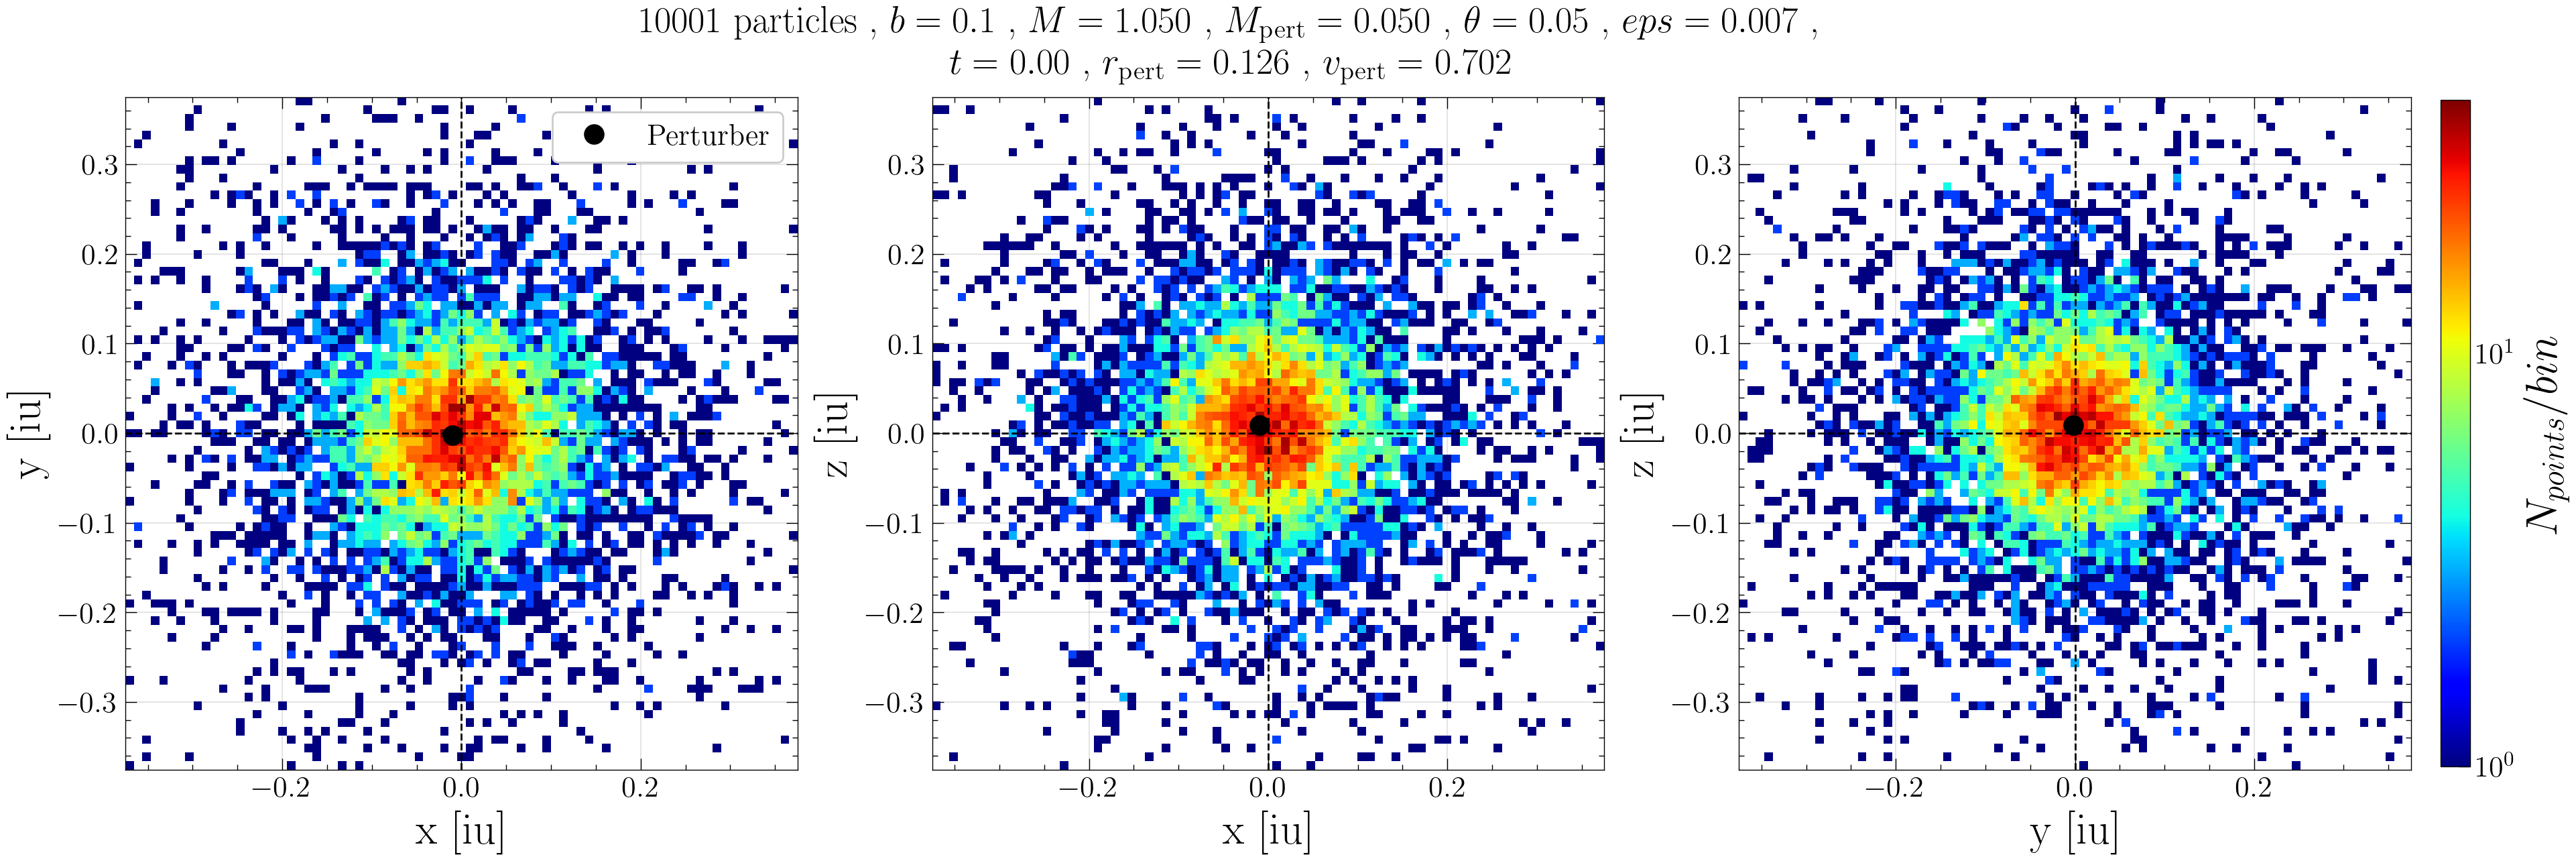

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{pert}}}} = {M_pert:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$ , $r_{{\\rm{{pert}}}} = {dist_pert[0]:.3f}$ , $v_{{\\rm{{pert}}}} = {v_pert[0]:.3f}$', fontsize=20, y=0.95)   

nbins = int(20*np.log10(N))
bins = np.linspace(-dist_plotlimits, dist_plotlimits, nbins)
time_i = -1

ax = axes[0]
ax.set_box_aspect(1)
ax.hist2d(x[:, time_i], y[:, time_i], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
ax.axvline(0, ls='--', lw=1,color='black')
ax.axhline(0, ls='--', lw=1,color='black')
ax.plot(x[-1, time_i], y[-1, time_i], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='Perturber')
ax.set_xlim(-dist_plotlimits,dist_plotlimits)
ax.set_ylim(-dist_plotlimits,dist_plotlimits)
ax.set_xlabel('x [iu]')
ax.set_ylabel('y [iu]')
ax.legend()

ax = axes[1]
ax.set_box_aspect(1)
ax.hist2d(x[:, time_i], z[:, time_i], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
ax.axvline(0, ls='--', lw=1,color='black')
ax.axhline(0, ls='--', lw=1,color='black')
ax.plot(x[-1, time_i], z[-1, time_i], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='Perturber')
ax.set_xlim(-dist_plotlimits,dist_plotlimits)
ax.set_ylim(-dist_plotlimits,dist_plotlimits)
ax.set_xlabel('x [iu]')
ax.set_ylabel('z [iu]')

ax = axes[2]
ax.set_box_aspect(1)
hist = ax.hist2d(y[:, time_i], z[:, time_i], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
ax.axvline(0, ls='--', lw=1,color='black')
ax.axhline(0, ls='--', lw=1,color='black')
ax.plot(y[-1, time_i], z[-1, time_i], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='Perturber')
ax.set_xlim(-dist_plotlimits,dist_plotlimits)
ax.set_ylim(-dist_plotlimits,dist_plotlimits)
ax.set_xlabel('y [iu]')
ax.set_ylabel('z [iu]')
cax = fig.add_axes([0.91, 0.14, 0.01, 0.71], label='$N_{points}/bin$')
fig.colorbar(hist[3], cax, label='$N_{points}/bin$');

In [17]:
animate_2Dhist = False
if animate_2Dhist:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{pert}}}} = {M_pert:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$ , $r_{{\\rm{{pert}}}} = {dist_pert[0]:.3f}$ , $v_{{\\rm{{pert}}}} = {v_pert[0]:.3f}$', fontsize=20, y=0.95)   
    
    def animate(i):
        t = k*i
        
        print(f'frame {(i+1)}/{nframes}, {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{pert}}}} = {M_pert:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[t]:.2f}$ , $r_{{\\rm{{pert}}}} = {dist_pert[t]:.3f}$ , $v_{{\\rm{{pert}}}} = {v_pert[t]:.3f}$')
        
        ax = axes[0]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(x[:, t], y[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(x[-1, t], y[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='Perturber')
        ax.set_xlim(-dist_plotlimits,dist_plotlimits)
        ax.set_ylim(-dist_plotlimits,dist_plotlimits)
        ax.set_xlabel('x [iu]')
        ax.set_ylabel('y [iu]')
        ax.legend()
    
        ax = axes[1]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(x[:, t], z[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(x[-1, t], z[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='Perturber')
        ax.set_xlim(-dist_plotlimits,dist_plotlimits)
        ax.set_ylim(-dist_plotlimits,dist_plotlimits)
        ax.set_xlabel('x [iu]')
        ax.set_ylabel('z [iu]')
    
        ax = axes[2]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(y[:, t], z[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(y[-1, t], z[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='Perturber')
        ax.set_xlim(-dist_plotlimits,dist_plotlimits)
        ax.set_ylim(-dist_plotlimits,dist_plotlimits)
        ax.set_xlabel('y [iu]')
        ax.set_ylabel('z [iu]')
        
        if i==0:
            cax = fig.add_axes([0.91, 0.14, 0.01, 0.71], label='$N_{points}/bin$')
            fig.colorbar(hist[3], cax, label='$N_{points}/bin$');
            
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=int(nframes/k), interval=1, blit=True)
    #ani.save('friction_2Dhist.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save('friction_2Dhist.mp4', writer=animation.FFMpegWriter(fps=40, bitrate=-1, codec='h264'), dpi=200)

# Radial and velocity distribution as a function of time

In [18]:
# Define radial bins
r_bins = np.linspace(0, np.max(np.quantile(dist_particle, 0.995, axis=0)), 40)

# Compute histogram of radial distances
hist_dist = np.zeros([len(r_bins)-1, len(dist_particle[0, :])])
for i in range(len(dist_particle[0, :])):
    hist_dist[:, i] = np.histogram(dist_particle[:, i], bins=r_bins)[0]

In [19]:
v_particle = np.sqrt(vx**2+vy**2+vz**2)

# Define radial bins
v_bins = np.linspace(0, np.max(np.quantile(v_particle, 0.995, axis=0)), 40)

# Compute histogram of radial distances
hist_v = np.zeros([len(v_bins)-1, len(v_particle[0, :])])
for i in range(len(v_particle[0, :])):
    hist_v[:, i] = np.histogram(v_particle[:, i], bins=v_bins)[0]

In [20]:
def Plot_Hists(t, r_bins, v_bins):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Histogram of the radial positions
    hist_dist_plot = hist_dist[:, t]
    
    ax = axes[0]
    ax.bar(r_bins[:-1], hist_dist_plot, width=np.diff(r_bins), color='lightblue', edgecolor="black", align="edge", label='Data')
    ax.plot(r_bins, np.sum(np.diff(r_bins)*hist_dist_plot) * (3*r_bins**2/b**3)*(1+r_bins**2/b**2)**(-5/2), color='red', label='Pdf(r)')
    ax.axvline(b, ls='--', color='black', label='r=b')
    ax.set_yscale('log')
    ax.set_ylim(bottom=1)
    ax.set_xlabel('Radial distance $[iu]$')
    ax.set_ylabel('Number of particles')
    ax.legend(loc='upper right')
    
    
    # Histogram of the velocities
    hist_v_plot = hist_v[:, t]
    
    ax = axes[1]
    ax.bar(v_bins[:-1], hist_v_plot, width=np.diff(v_bins), color='lightblue', edgecolor="black", align="edge")
    ax.set_xlabel('Velocity $[iu$')
    ax.set_ylim(0, np.max(hist_v))
    
    return fig, axes

In [21]:
animate_hist = False

if animate_hist:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    ax = axes
    title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{pert}}}} = {M_pert:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$ , $r_{{\\rm{{pert}}}} = {dist_pert[0]:.3f}$ , $v_{{\\rm{{pert}}}} = {v_pert[0]:.3f}$', fontsize=20, y=0.95)   
    
    def animate(i):
        print(math.ceil(100*i*k/len(hist_dist[0, :])), "%", end='\r')
        
        title.set_text(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{pert}}}} = {M_pert:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[k*i]:.2f}$ , $r_{{\\rm{{pert}}}} = {dist_pert[k*i]:.3f}$ , $v_{{\\rm{{pert}}}} = {v_pert[k*i]:.3f}$')
        
        # Histogram of the radial positions
        hist_dist_plot = hist_dist[:, k*i]

        ax = axes[0]
        ax.clear()
        ax.bar(r_bins[:-1], hist_dist_plot, width=np.diff(r_bins), color='lightblue', edgecolor="royalblue", align="edge", label='Data')
        ax.plot(r_bins, np.sum(np.diff(r_bins)*hist_dist_plot) * (3*r_bins**2/b**3)*(1+r_bins**2/b**2)**(-5/2), color='red', label='Pdf(r)')
        ax.axvline(b, ls='--', color='black', label='r=b')
        ax.set_xlim(0)
        ax.set_yscale('log')
        ax.set_ylim(1, 1.05*np.max(hist_dist))
        ax.set_xlabel('Radial distance $[iu]$')
        ax.set_ylabel('Number of particles')
        ax.legend(loc='upper right')
        
        
        # Histogram of the velocities
        hist_v_plot = hist_v[:, k*i]

        ax = axes[1]
        ax.clear()
        ax.bar(v_bins[:-1], hist_v[:, 0], width=np.diff(v_bins), color='white', edgecolor="red", align="edge")
        ax.bar(v_bins[:-1], hist_v_plot, width=np.diff(v_bins), color='lightblue', edgecolor="royalblue", align="edge")
        ax.set_xlim(0)
        ax.set_xlabel('Velocity $[iu]$')
        ax.set_ylim(0, 1.05*np.max(hist_v))
            
        return fig,
    
    writer = animation.FFMpegWriter(fps=60)
    ani = animation.FuncAnimation(fig, animate, frames=int(len(hist_dist[0, :])/k), interval=1, blit=True)
    ani.save('friction_1Dhist.gif', writer=writer, dpi=100)

# Distance quantiles

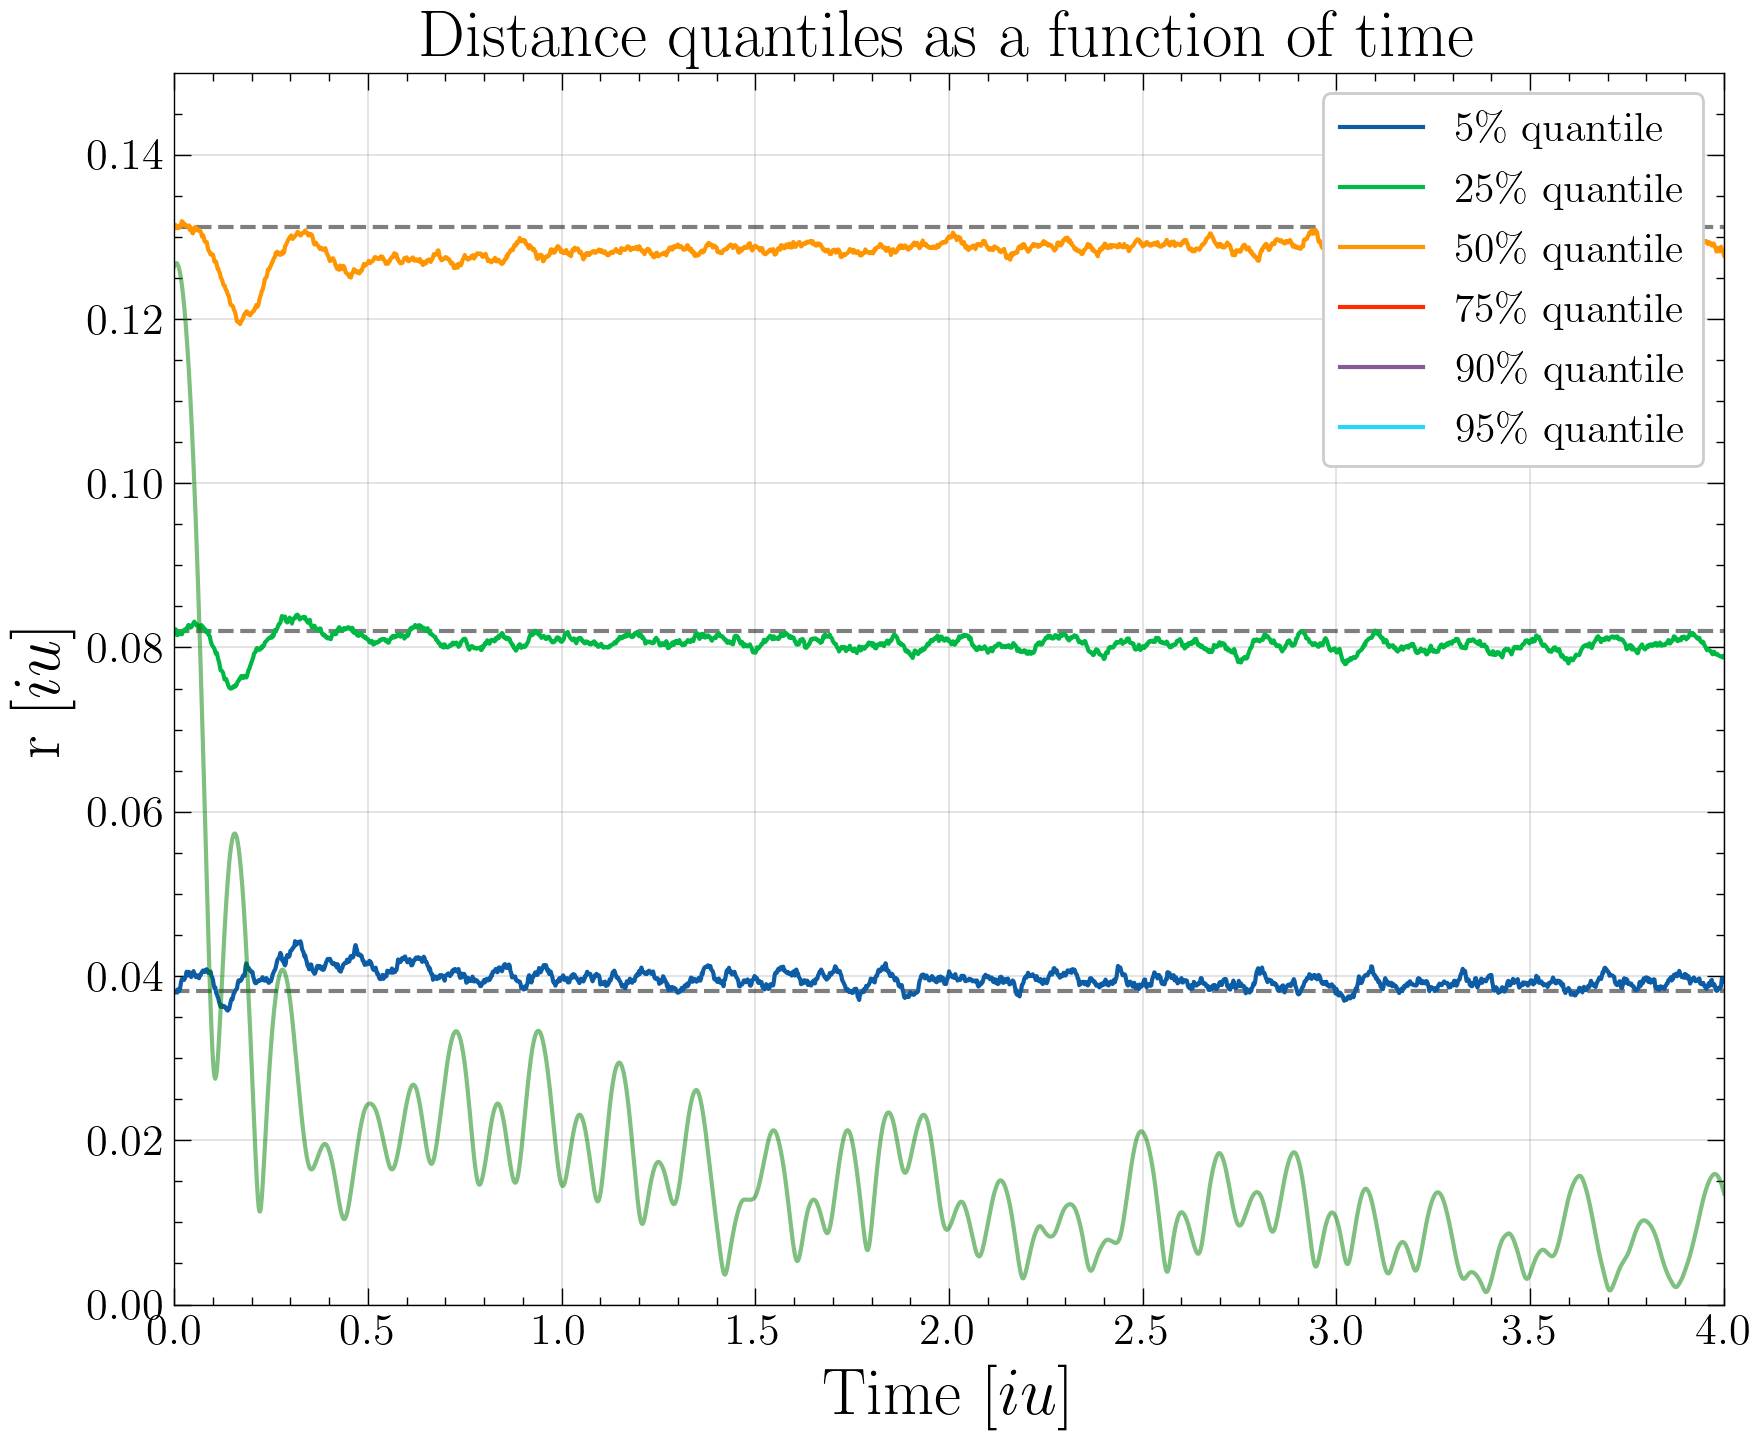

In [22]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.9, 0.95]
dist_quantiles = np.quantile(dist_particle, quantiles, axis=0)
for i in range(len(quantiles)):
    plt.axhline(dist_quantiles[i][0], ls='--', color='black', alpha=0.5)
    plt.plot(time, dist_quantiles[i], label=f'{int(100*quantiles[i])}\% quantile')
plt.plot(time, dist_pert, color='green', alpha=0.5)
plt.xlim(0, time[-1])
plt.ylim(0, 0.15)
plt.title('Distance quantiles as a function of time')
plt.xlabel('Time $[iu]$')
plt.ylabel('r $[iu]$')
plt.legend(loc='upper right', fontsize=15);

# Density profile

In [23]:
r_bins_rho = r_bins[:-1] + np.diff(r_bins)

rho = np.ones([len(r_bins_rho), len(time)])
for i in range(len(r_bins_rho)):
    volume = (4*np.pi/3)*r_bins_rho[i]**3
    rho[i,:] = (M/N)*np.sum(dist_particle<r_bins_rho[i], axis=0)/volume

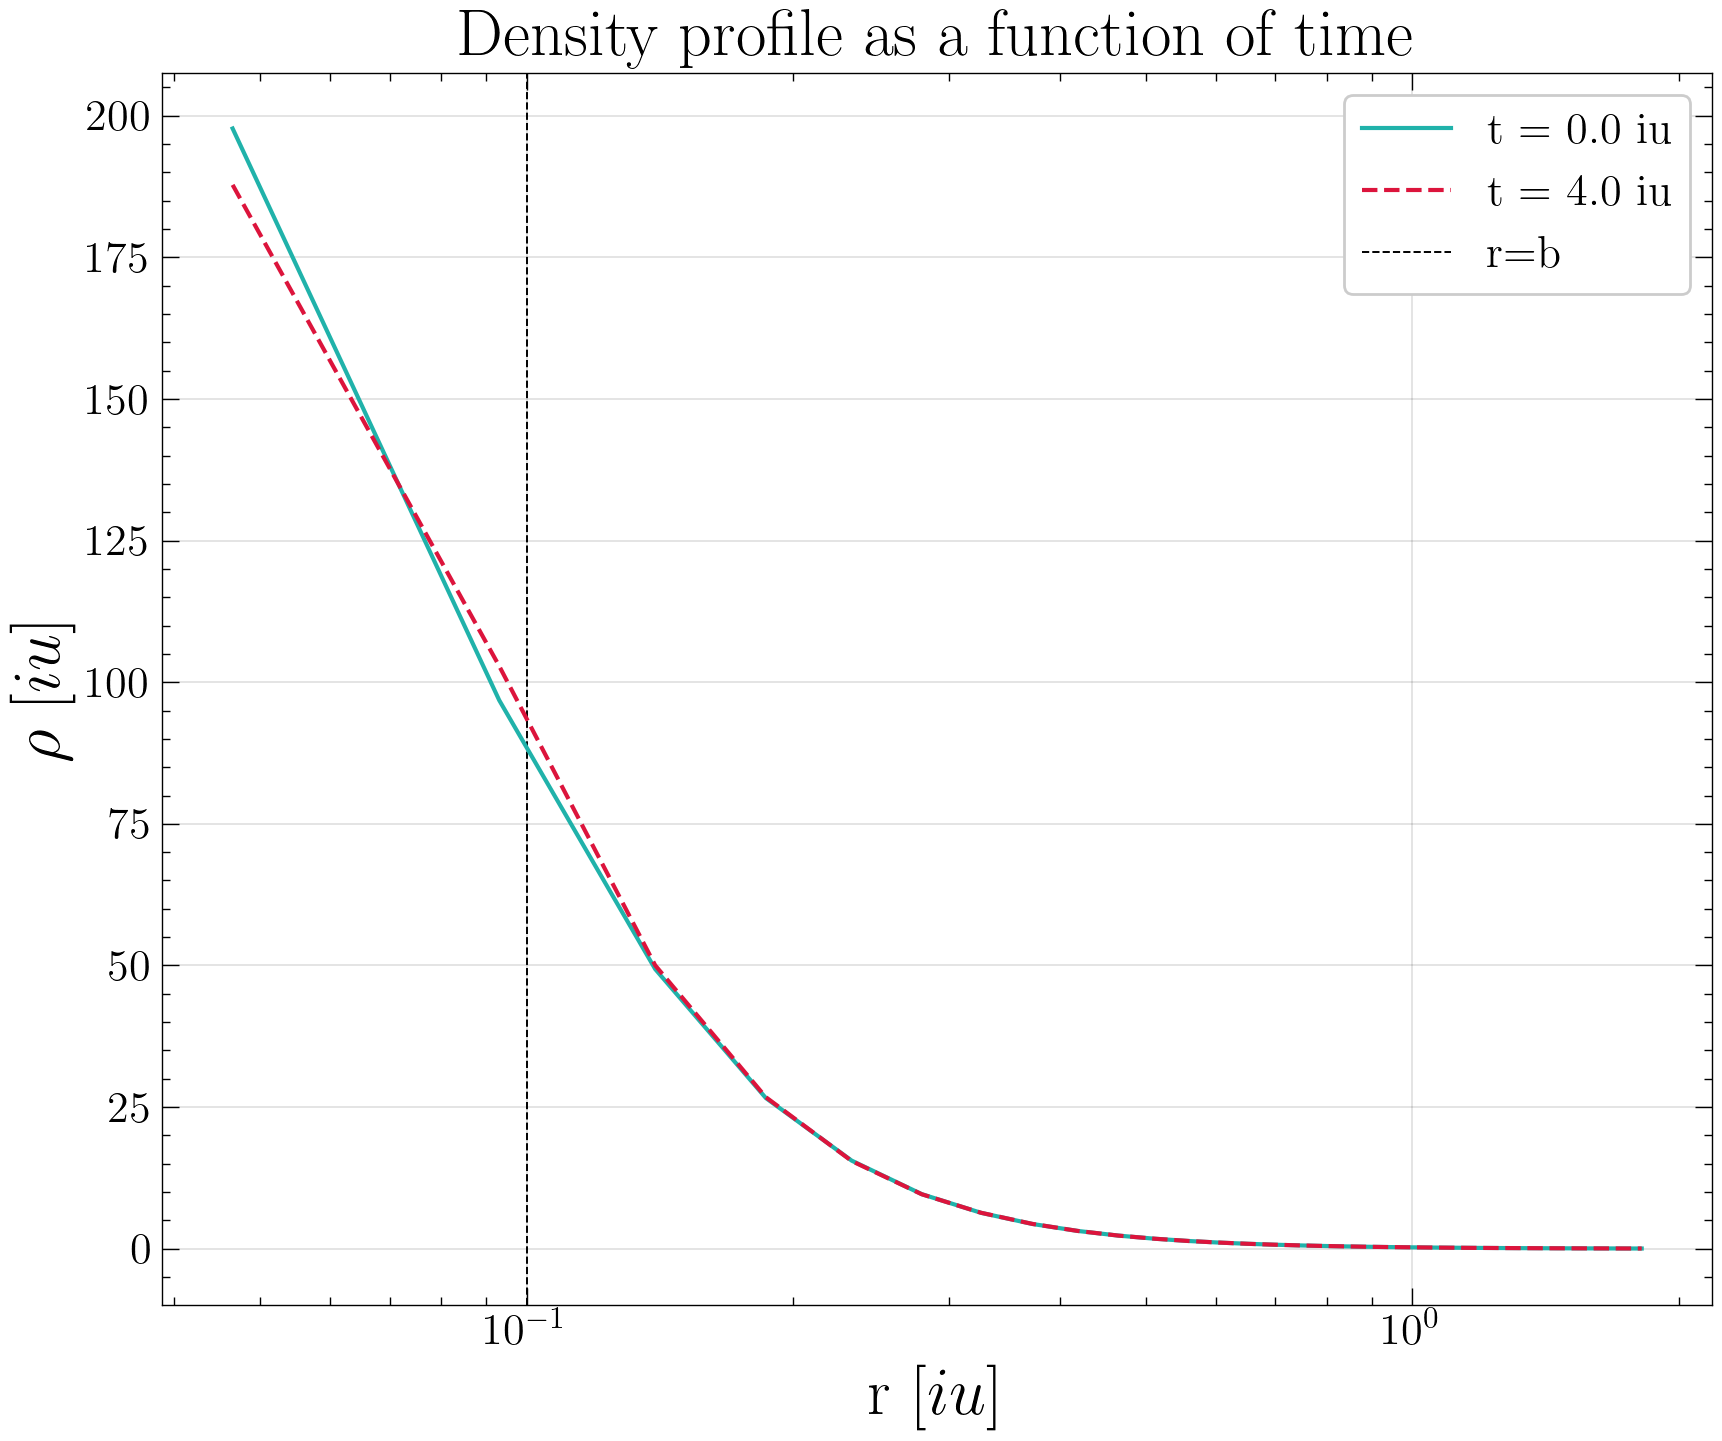

In [24]:
plt.plot(r_bins_rho, rho[:,0], color='lightseagreen', label=f't = {time[0]:.1f} iu')
plt.plot(r_bins_rho, rho[:,-1], color='crimson', ls='--', label=f't = {time[-1]:.1f} iu')
plt.axvline(b, color='black', ls='--', lw=0.7, label='r=b', zorder=0)
plt.xscale('log')
plt.title('Density profile as a function of time')
plt.xlabel('r $[iu]$')
plt.ylabel('$\\rho$ $[iu]$')
plt.legend();